# Confronto tra le medie di due gruppi {#sec-stan-two-means}

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [1]:
import statistics as st
import warnings
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
warnings.filterwarnings("ignore")

In [2]:
seed: int = sum(map(ord, "regr_model_two_means"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

## Introduzione

Nel @sec-two-groups-comparison, abbiamo discusso come eseguire l'inferenza sulla differenza tra le medie di due campioni indipendenti attraverso un approccio bayesiano. In quella analisi, i due gruppi sono stati trattati come entità distinte e abbiamo calcolato la differenza tra le loro medie.

Un'alternativa consiste nell'uso di un modello di regressione. In questo caso, non si calcola direttamente la differenza tra le medie, ma si introduce una variabile "dummy" nel modello di regressione. La variabile "dummy" codifica l'appartenenza ai gruppi con valori binari: 0 per il gruppo di riferimento e 1 per il gruppo di confronto. Il modello di regressione stima poi un coefficiente per la variabile "dummy", che rappresenta la differenza tra le medie dei due gruppi. Così facendo, la variabile "dummy" agisce come un indicatore del gruppo, permettendoci di stimare in modo efficiente la differenza tra le medie.

Entrambi i metodi sono validi per analizzare la differenza tra le medie di due gruppi indipendenti, tuttavia il modello di regressione offre maggiore flessibilità e potenzialità di espansione. Grazie a questo modello, è possibile includere ulteriori variabili esplicative, ampliando la nostra capacità di comprendere i fattori che influenzano il risultato d'interesse. Questa versatilità è particolarmente vantaggiosa per esaminare come altre variabili possano influire sulla differenza tra le medie o per analizzare più variabili contemporaneamente.

## Regressione bayesiana per due gruppi indipendenti

Nel contesto bayesiano, il modello di regressione può essere formulato nel modo seguente:

$$
\begin{align*}
y_i & \sim \mathcal{N}(\mu_i, \sigma), \\
\mu_i & = \alpha + \beta x_i.
\end{align*}
$$

In questa rappresentazione:

- $ \alpha $ agisce come intercetta,
- $ \beta $ è il coefficiente angolare o la pendenza,
- $ \sigma $ è l'errore standard associato alle osservazioni.

Nel caso specifico, la variabile $ x $ è una variabile indicatrice che assume i valori 0 o 1. Per il gruppo identificato da $ x = 0 $, il modello si riduce a:

$$
\begin{align*}
y_i & \sim \mathcal{N}(\mu_i, \sigma), \\
\mu_i & = \alpha.
\end{align*}
$$

Questo implica che $ \alpha $ rappresenta la media del gruppo codificato come $ x = 0 $.

Per il gruppo contrassegnato da $ x = 1 $, il modello diventa:

$$
\begin{align*}
y_i & \sim \mathcal{N}(\mu_i, \sigma), \\
\mu_i & = \alpha + \beta.
\end{align*}
$$

In termini dei parametri del modello, la media per il gruppo codificato con $ x = 1 $ è rappresentata da $ \alpha + \beta $. In questa configurazione, $ \beta $ indica la differenza tra la media del gruppo con $ x = 1 $ e quella del gruppo con $ x = 0 $. Di conseguenza, l'analisi della differenza tra le medie dei due gruppi può essere effettuata attraverso l'inferenza sul parametro $ \beta $. In sintesi, per confrontare le medie dei due gruppi indipendenti, si può esaminare la distribuzione a posteriori di $ \beta $.

## Un esempio illustrativo

Esaminiamo nuovamente i dati relativi al quoziente di intelligenza dei bambini le cui madri hanno completato oppure no la scuola superiore. Ci poniamo il problema di replicare i risultati ottenuti in precedenza usando l'analisi di regressione.

Leggiamo i dati:

In [3]:
kidiq = pd.read_stata("../../data/kidiq.dta")
kidiq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


In [4]:
kidiq.groupby(["mom_hs"]).size()

mom_hs
0.0     93
1.0    341
dtype: int64

Ci sono 93 bambini la cui madre non ha completato le superiori e 341 bambini la cui madre ha ottenuto il diploma di scuola superiore.

In [4]:
summary_stats = [st.mean, st.stdev]
kidiq.groupby(["mom_hs"]).aggregate(summary_stats)

kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

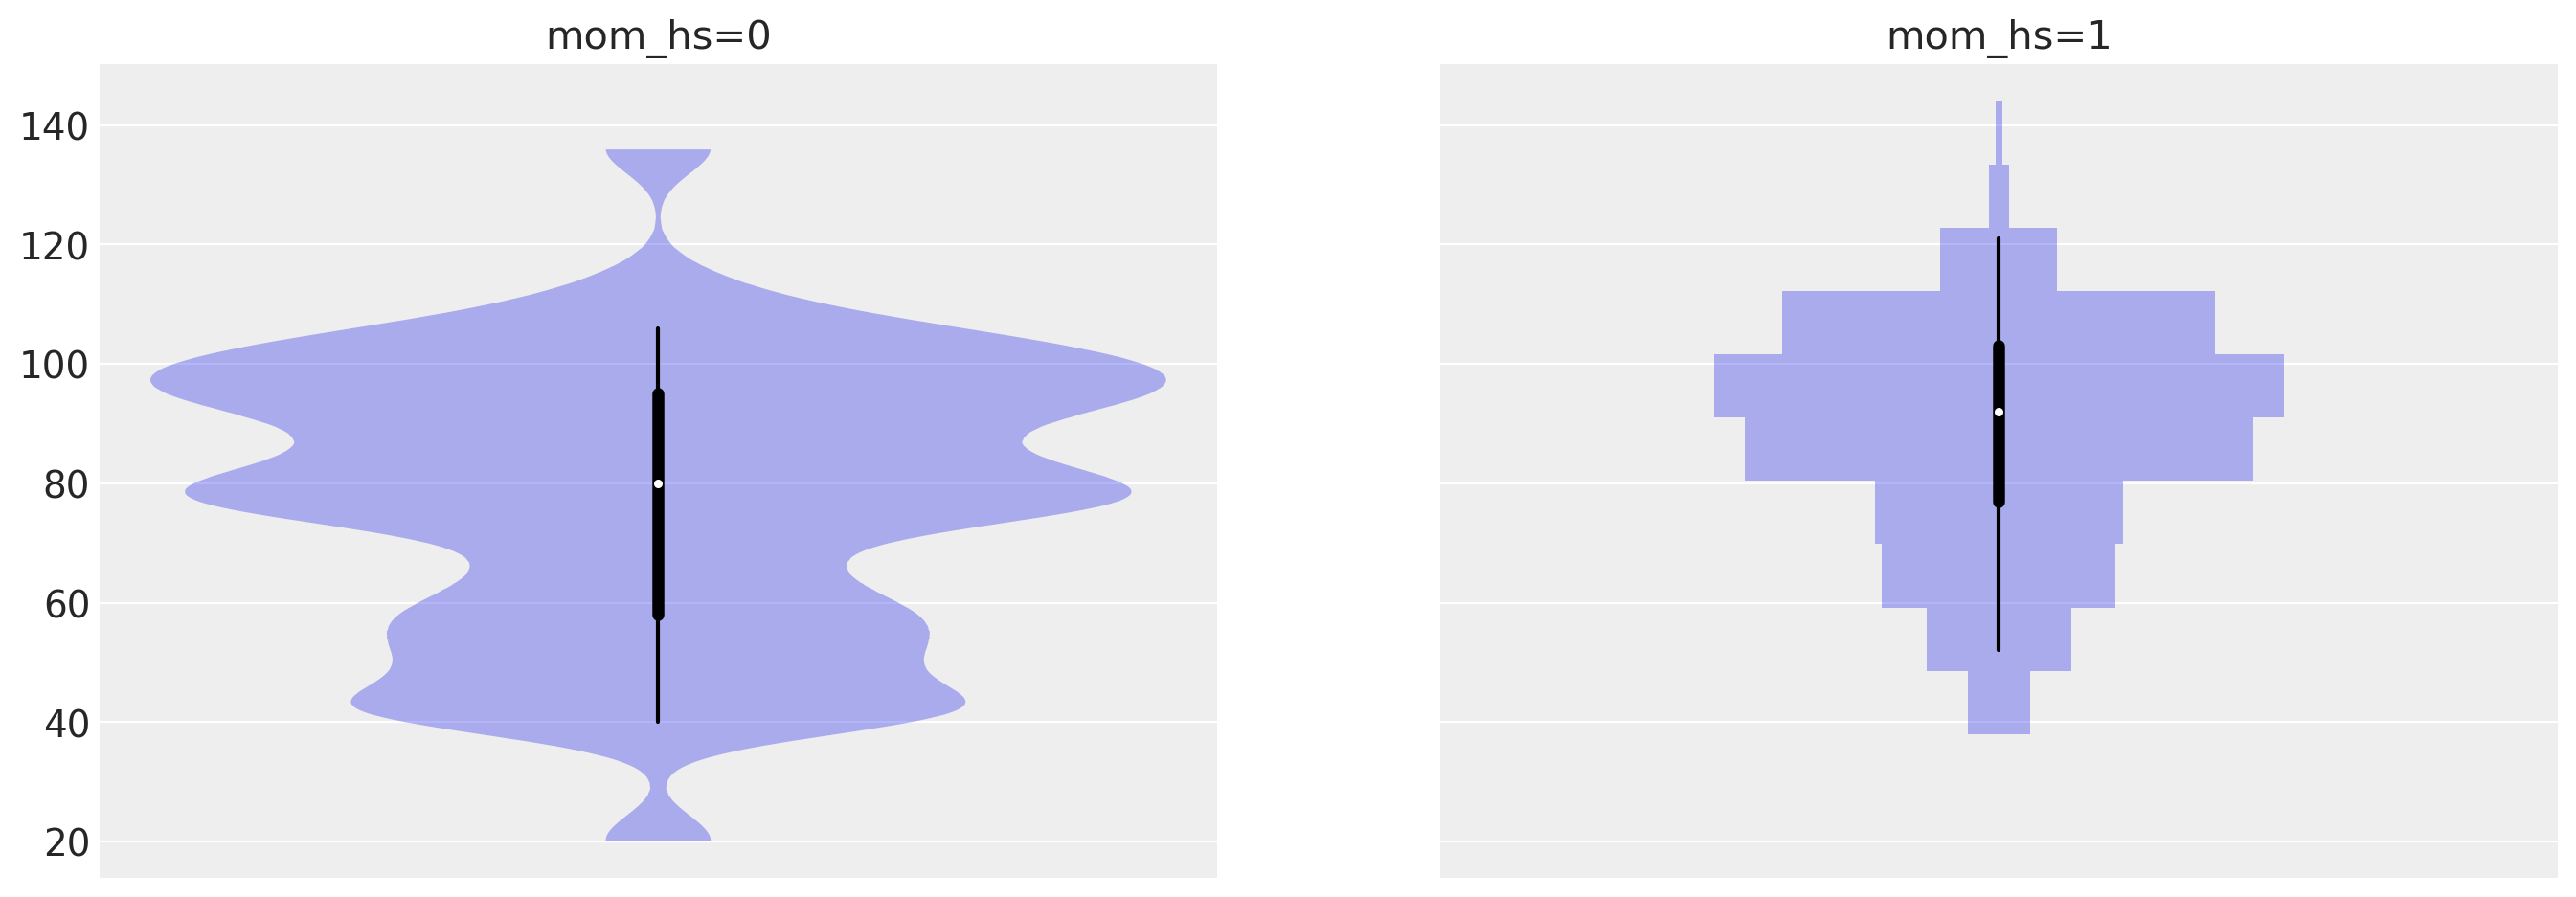

In [5]:
az.plot_violin(
    {
        "mom_hs=0": kidiq.loc[kidiq.mom_hs == 0, "kid_score"],
        "mom_hs=1": kidiq.loc[kidiq.mom_hs == 1, "kid_score"],
    }
);

Iniziamo l'inferenza statistica sulla differenza tra le medie dei due gruppi utilizzando `bambi`. Questo pacchetto offre una sintassi semplice per formulare il modello bayesiano di interesse. Un altro vantaggio è che `bambi` selezionerà automaticamente le distribuzioni a priori appropriate per i parametri del modello, rendendo il processo più intuitivo.

Il modello di regressione sopra descritto si scrive nel modo seguente.

In [7]:
mod = bmb.Model("kid_score ~ mom_hs", kidiq)

Effettuiamo il campionamento.

In [8]:
results = mod.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Possiamo ispezionare le proprietà del modello nel modo seguente.

In [9]:
mod

       Formula: kid_score ~ mom_hs
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 86.7972, sigma: 110.1032)
            mom_hs ~ Normal(mu: 0.0, sigma: 124.2132)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Le distribuzioni a priori utilizzate di default dal modello possono essere visualizzate nel modo seguente.

Sampling: [Intercept, kid_score_sigma, mom_hs]


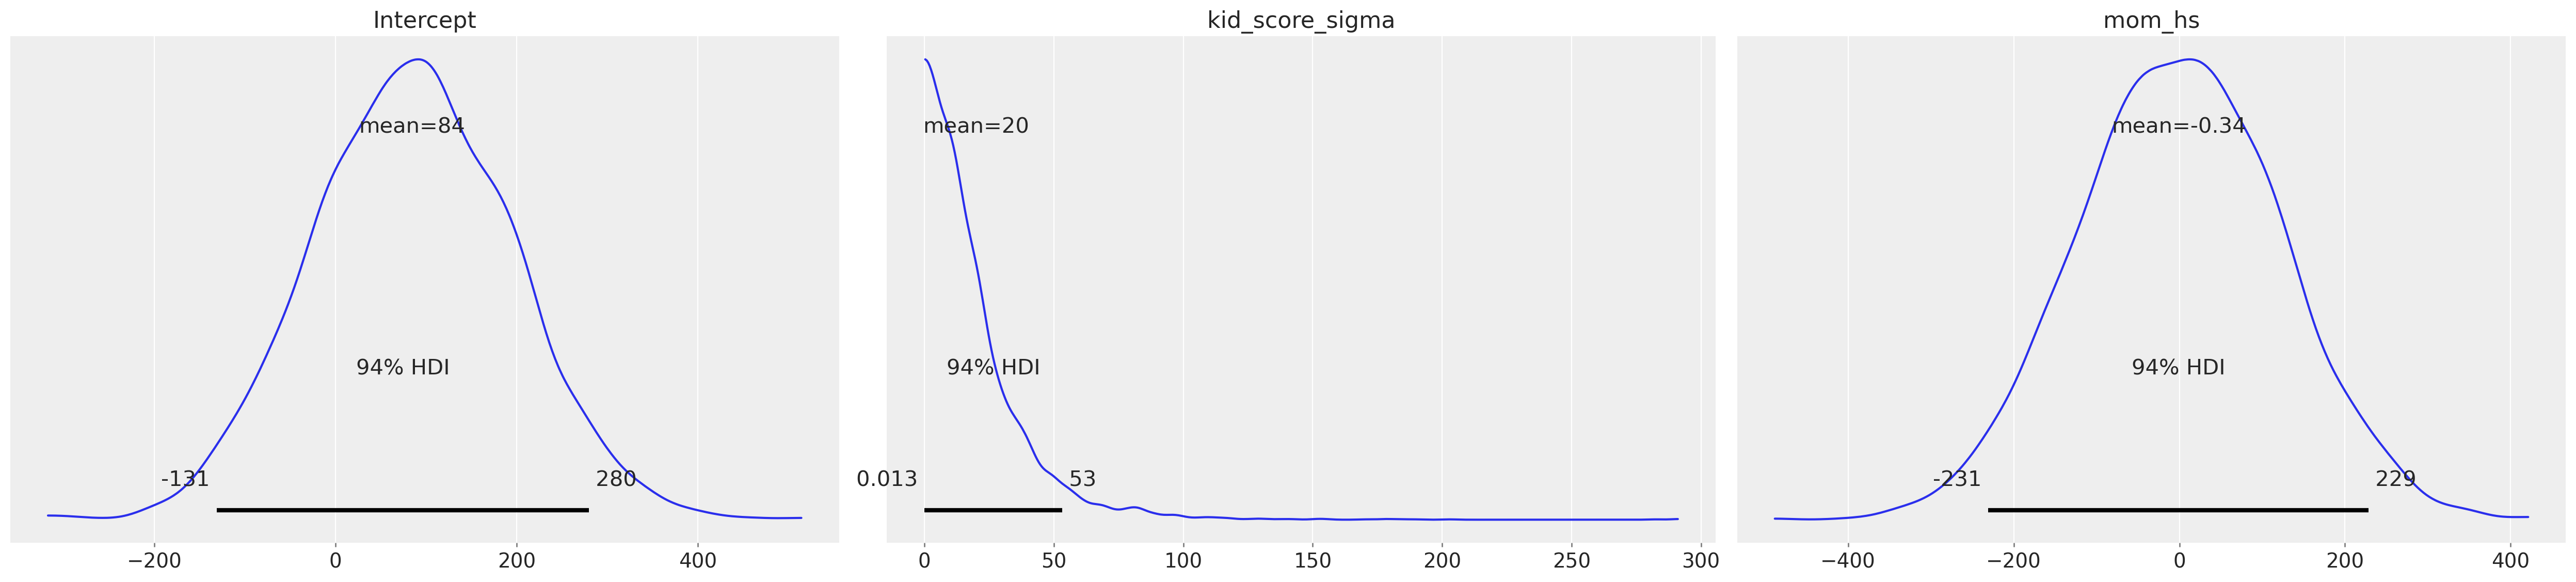

In [10]:
_ = mod.plot_priors()

Per ispezionare il nostro posteriore e il processo di campionamento possiamo utilizzare `az.plot_trace()`. L'opzione `kind='rank_vlines'` ci fornisce una variante del grafico di rango che utilizza linee e punti e ci aiuta a ispezionare la stazionarietà delle catene. Poiché non c'è un modello chiaro o deviazioni serie dalle linee orizzontali, possiamo concludere che le catene sono stazionarie.

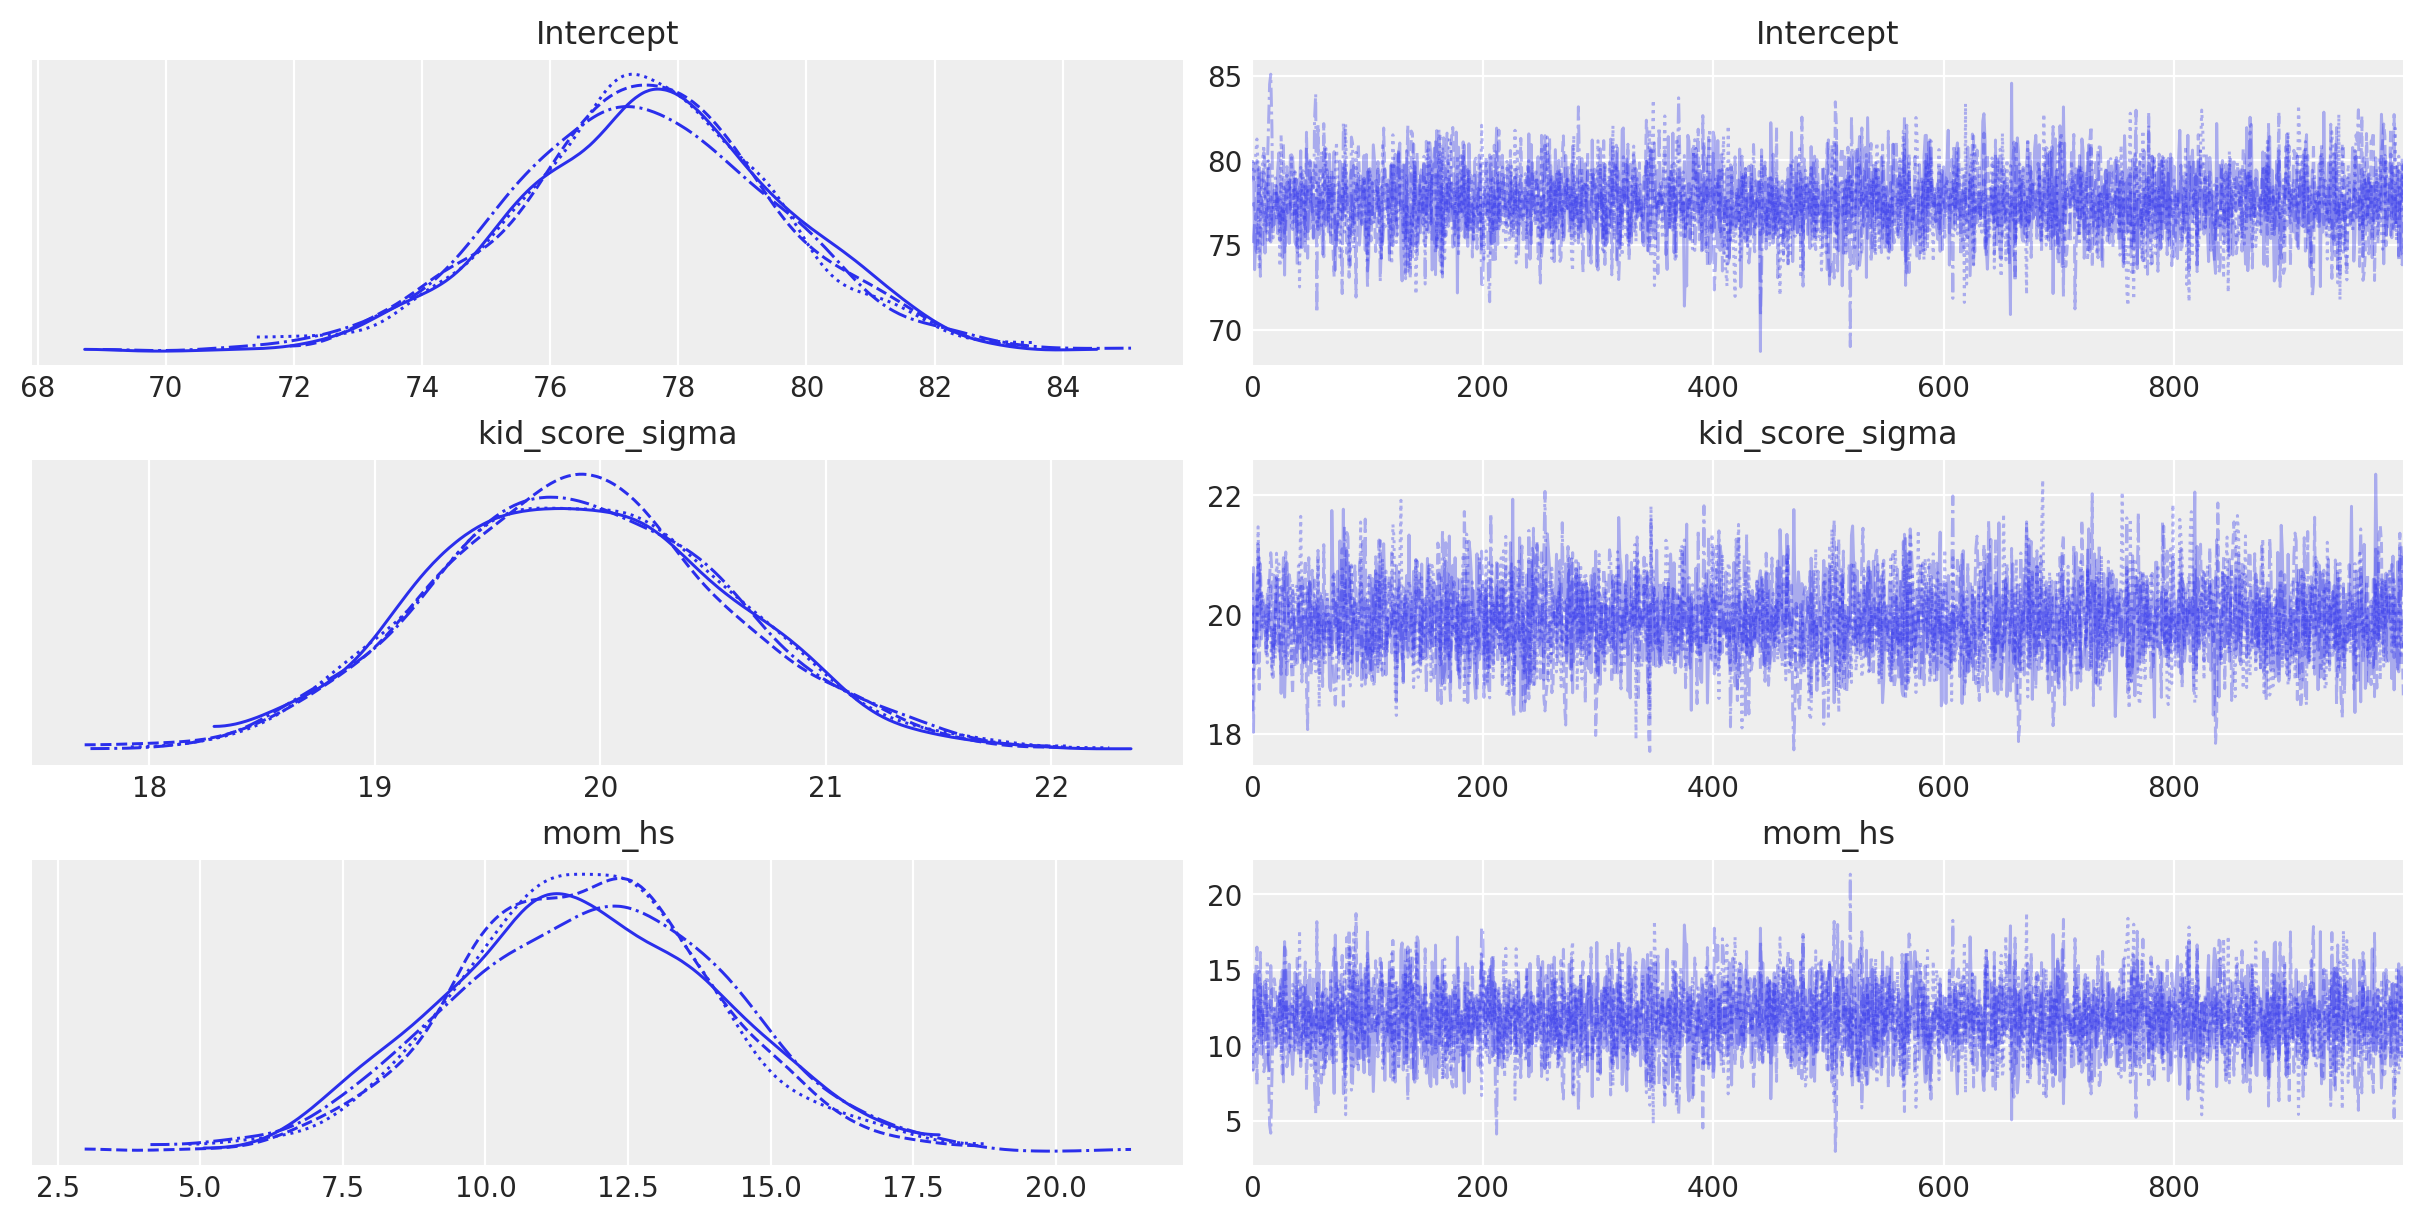

In [11]:
_ = az.plot_trace(results)

In [12]:
az.summary(results, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,77.52,2.04,73.72,81.48,0.03,0.02,4640.52,3274.01,1.0
kid_score_sigma,19.91,0.67,18.68,21.19,0.01,0.01,4231.42,3052.91,1.0
mom_hs,11.78,2.30,7.23,15.86,0.03,0.02,4642.76,3108.48,1.0


Il parametro "Intercept" rappresenta la stima a posteriori del punteggio del QI per il gruppo codificato con "mom_hs" uguale a 0. La media a posteriori di questo gruppo è di 77.6, che è praticamente identica al valore campionario corrispondente.

Il parametro "mom_hs" corrisponde alla stima a posteriori della differenza nei punteggi del QI tra il gruppo codificato con "mom_hs" uguale a 1 e il gruppo codificato con "mom_hs" uguale a 0. Anche in questo caso, la differenza a posteriori di 11.8 tra le medie dei due gruppi è molto simile alla differenza campionaria tra le medie dei due gruppi. La parte importante della tabella riguarda l'intervallo di credibilità al 94%, che è [7.5, 16.2], e che non include lo 0. Ciò significa che, con un livello di certezza soggettiva del 94%, possiamo essere sicuri che il QI dei bambini le cui madri hanno il diploma superiore sarà maggiore (in media) di almeno 7.5 punti, e tale differenza può arrivare fino a 16.2 punti, rispetto al QI dei bambini le cui madri non hanno completato la scuola superiore.

Se confrontiamo questi risultati con quelli ottenuti nel capitolo {ref}`two_groups_comparison_notebook`, notiamo che sono quasi identici. Le piccole differenze che si osservano possono essere attribuite sia all'approssimazione numerica sia al fatto che nel modello precedente abbiamo consentito deviazioni standard diverse per i due gruppi, mentre nel caso attuale abbiamo assumo la stessa variabilità per entrambi i gruppi.

Usiamo ora l'approccio di massima verosimiglianza.

In [13]:
lm = pg.linear_regression(kidiq["mom_hs"], kidiq["kid_score"])
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,77.55,2.06,37.67,0.0,0.06,0.05,73.50,81.59
1,mom_hs,11.77,2.32,5.07,0.0,0.06,0.05,7.21,16.34


I risultati sono quasi identici a quelli trovati con l'approccio bayesiano.

Il test bayesiano di ipotesi può essere svolto, per esempio, calcolando la probabilità che $\beta_{mean\_diff} > 0$. Questa probabilità è 1, per cui concludiamo che la media del gruppo codificato con "mom_hs = 1" è maggiore della media del gruppo codificato con "mom_hs = 0". 

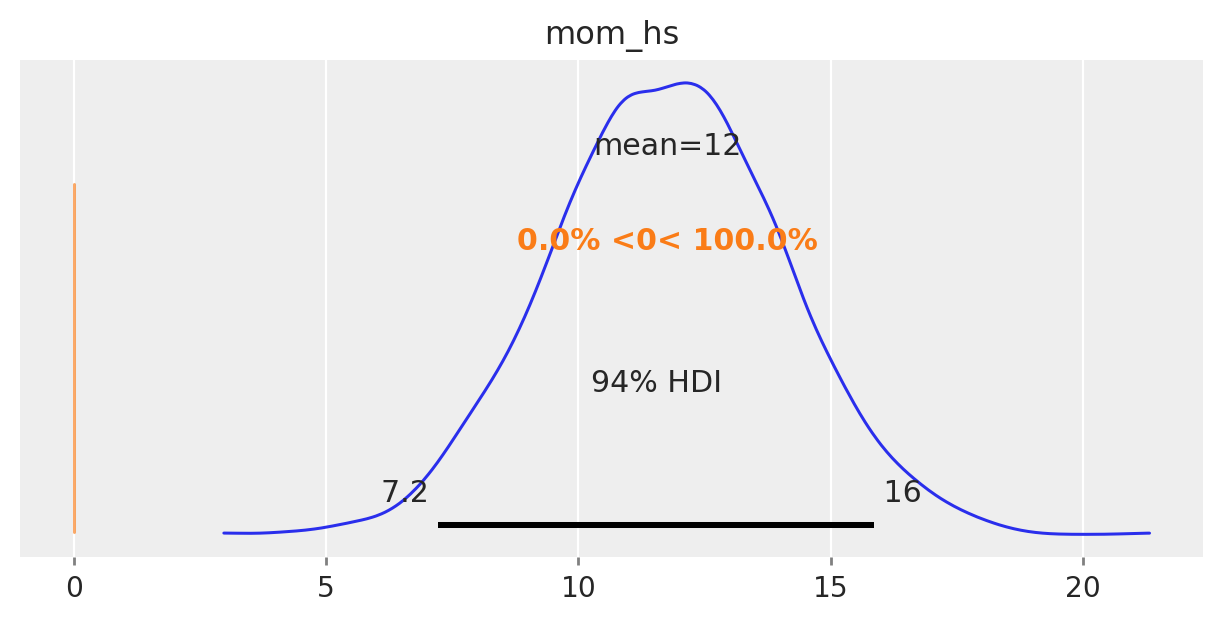

In [14]:
az.plot_posterior(results, var_names="mom_hs", ref_val=0, figsize=(6, 3));

Un valore numerico si ottiene nel modo seguente.

In [15]:
results.posterior

<xarray.Dataset> Size: 104kB
Dimensions:          (chain: 4, draw: 1000)
Coordinates:
  * chain            (chain) int64 32B 0 1 2 3
  * draw             (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    Intercept        (chain, draw) float64 32kB 78.83 79.84 ... 73.83 79.82
    kid_score_sigma  (chain, draw) float64 32kB 19.21 20.79 ... 20.87 19.45
    mom_hs           (chain, draw) float64 32kB 11.97 8.374 ... 15.15 10.02
Attributes:
    created_at:                  2024-06-13T05:14:43.527326+00:00
    arviz_version:               0.18.0
    modeling_interface:          bambi
    modeling_interface_version:  0.13.0

In [16]:
# Probabiliy that posterior is > 0
(results.posterior["mom_hs"] > 0).mean().item()

1.0

## Parametrizzazione alternativa

Consideriamo adesso il caso in cui, per distinguere i gruppi, anziché una variabile dicotomica, con valori 0 e 1, usiamo una variabile qualitativa con i nomi dei due gruppi. Introduciamo questa nuova variabile nel data frame.

In [17]:
# Add a new column 'hs' with the categories based on 'mom_hs'
kidiq["hs"] = kidiq["mom_hs"].map({0: "not_completed", 1: "completed"})
kidiq.tail()

,kid_score,mom_hs,mom_iq,mom_work,mom_age,hs
429,94,0.0,84.877412,4,21,not_completed
430,76,1.0,92.990392,4,23,completed
431,50,0.0,94.859708,2,24,not_completed
432,88,1.0,96.856624,2,21,completed
433,70,1.0,91.253336,2,25,completed


Adattiamo il modello ai dati, usando questa nuova variabile e forziamo a zero l'intercetta che Bambi aggiunge di default al modello.

In [18]:
mod_2 = bmb.Model("kid_score ~ 0 + hs", kidiq)
results_2 = mod_2.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Ispezionare il modello e le distribuzioni a priori.

In [19]:
mod_2

       Formula: kid_score ~ 0 + hs
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            hs ~ Normal(mu: [0. 0.], sigma: [124.2132 124.2132])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [hs, kid_score_sigma]


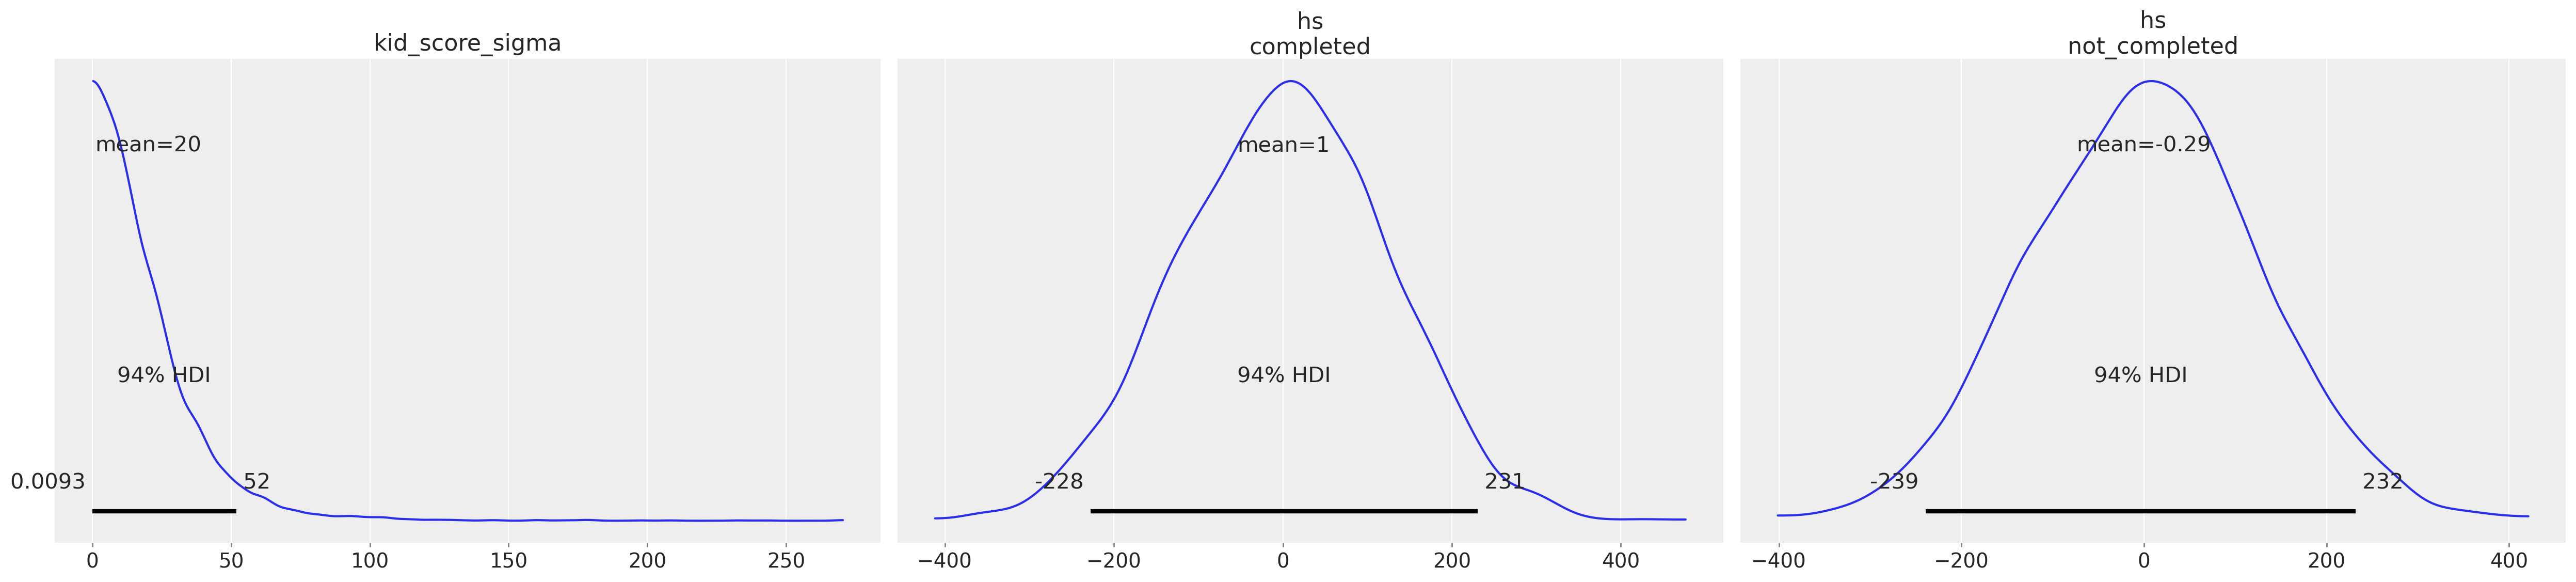

In [20]:
_ = mod_2.plot_priors()

Esaminiamo le distribuzioni a posteriori dei parametri del modello.

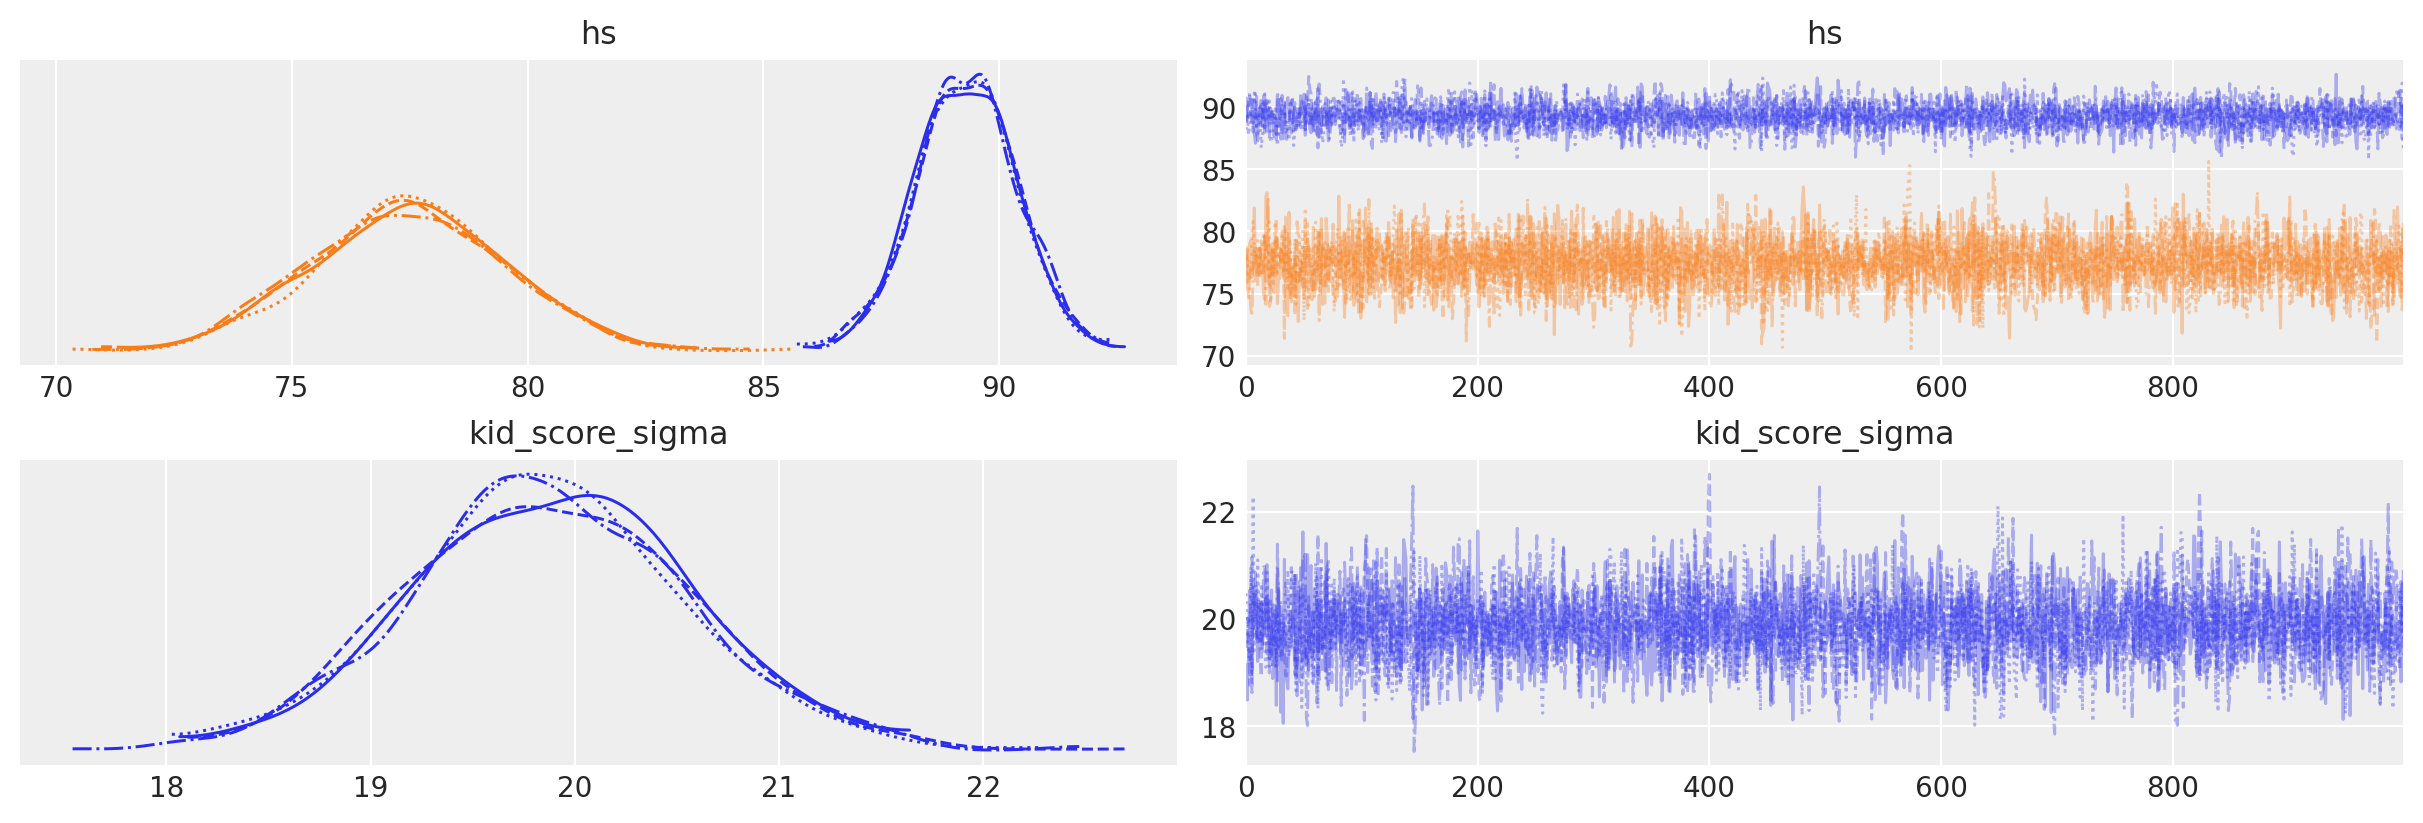

In [21]:
_ = az.plot_trace(results_2)

In [22]:
az.summary(results_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hs[completed],89.301,1.059,87.267,91.258,0.016,0.012,4147.0,3064.0,1.0
hs[not_completed],77.473,2.048,73.722,81.256,0.031,0.022,4308.0,3016.0,1.0
kid_score_sigma,19.881,0.680,18.621,21.181,0.011,0.008,3982.0,2995.0,1.0


In questo caso, notiamo che abbiamo ottenuto le distribuzioni a posteriori per i parametri `hs[completed]` e `hs[not_completed]` che corrispondono alle medie dei due gruppi. Tali distribuzioni a posteriori illustrano direttamente l'incertezza sulla media dei due gruppi, alla luce della variabilità campionaria e delle nostre credenze a priori.

Possiamo svolgere il test bayesiano di ipotesi sulla differenza tra le due medie a posteriori nel modo seguente.

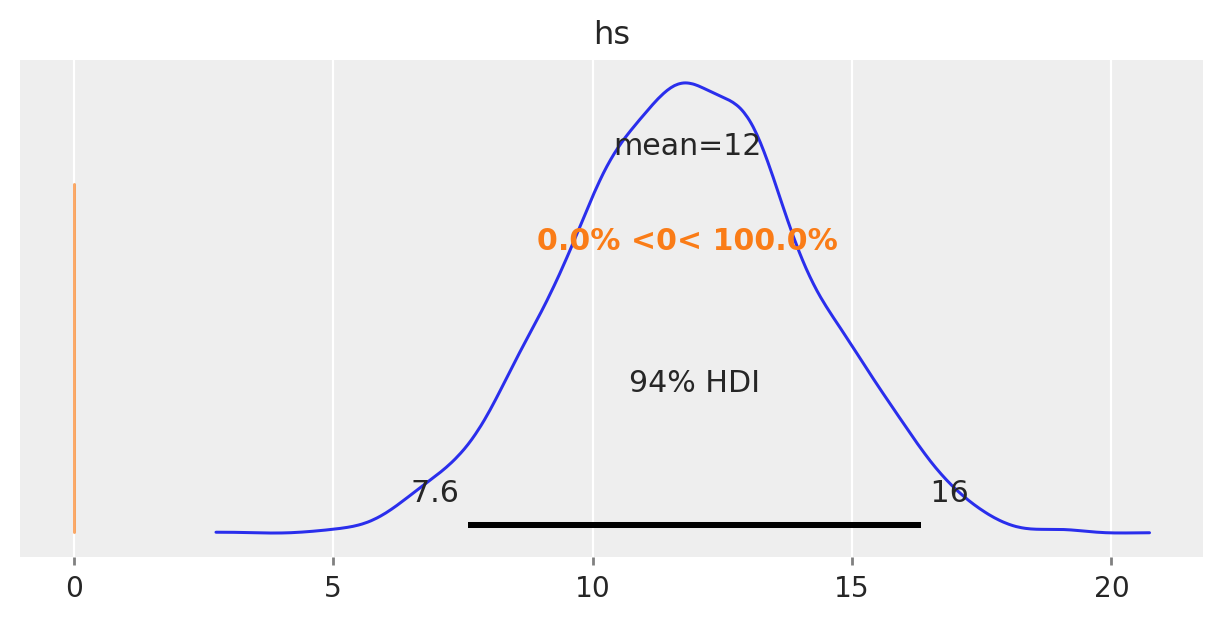

In [23]:
post_group = results_2.posterior["hs"]
diff = post_group.sel(hs_dim="completed") - post_group.sel(hs_dim="not_completed")
az.plot_posterior(diff, ref_val=0, figsize=(6, 3));

In [24]:
# Probabiliy that posterior is > 0
(post_group > 0).mean().item()

1.0

## Informazioni sull'Ambiente di Sviluppo

In [6]:
%load_ext watermark
%watermark -n -u -v -iv -w -m 

Last updated: Tue Jul 23 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

arviz     : 0.18.0
numpy     : 1.26.4
bambi     : 0.14.0
pandas    : 2.2.2
pingouin  : 0.5.4
matplotlib: 3.9.1

Watermark: 2.4.3

